In [30]:
import sys
import os
import cv2
import matplotlib.pyplot as plt
import psutil

# Add the root of the project to the path
sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

In [31]:
import pandas as pd
from utils.image_processing import process_row

source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
#train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_w_image_paths.csv")
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_patches_cc.csv")

In [32]:
train_df.head()

,writer,same_text,isEng,train,file_name,male,x,y,x2,y2,n_cc
0,190,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,988,494,1482,988,315
1,24,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,990,495,1485,990,311
2,26,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,494,1976,988,2470,309
3,190,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,1,494,494,988,988,303
4,160,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1482,494,1976,988,297


In [71]:
def process_image_at_index(i,patch=False,binarization_method='adaptive', keypoint_method='sift', 
                           denoising_method='fastNlMeans', skip=None):
    # Get the file path from train_df
    file_path = train_df.loc[i, 'file_name']
    
    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if patch:
        # Extract the patch using x, y, x2, y2
        x, y, x2, y2 = train_df.loc[i, ['x', 'y', 'x2', 'y2']]
        image = image[y:y2, x:x2]
        
    if image is None:
        raise FileNotFoundError(f"Image at {file_path} could not be loaded.")
    
    # Check if skip is provided and contains specific steps
    skip = skip or []
    
    # Apply denoising if not skipped
    if 'denoising' not in skip:
        if denoising_method == 'fastNlMeans':
            denoised_image = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
        elif denoising_method == 'gaussian':
            denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
        elif denoising_method == 'median':
            denoised_image = cv2.medianBlur(image, 5)
        else:
            raise ValueError("Unsupported denoising method. Choose 'fastNlMeans', 'gaussian', or 'median'.")
    else:
        denoised_image = image
    
    # Apply binarization if not skipped
    if 'binarization' not in skip:
        if binarization_method == 'adaptive':
            binarized_image = cv2.adaptiveThreshold(denoised_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                    cv2.THRESH_BINARY, 11, 2)
        elif binarization_method == 'otsu':
            _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            raise ValueError("Unsupported binarization method. Choose 'adaptive' or 'otsu'.")
    else:
        binarized_image = denoised_image
    
    # Apply keypoint detection if not skipped
    if 'keypoint_detection' not in skip:
        if keypoint_method == 'sift':
            sift = cv2.SIFT_create()
            keypoints, _ = sift.detectAndCompute(binarized_image, None)
        elif keypoint_method == 'orb':
            orb = cv2.ORB_create(
                nfeatures=300,            # Increase to detect more keypoints
                #scaleFactor=1.2,           # Standard (lower if you want to detect finer details at smaller scales)
                #nlevels=8,                 # More pyramid levels to detect varying size features
                #edgeThreshold=5,           # Smaller to detect features closer to the edge of strokes
                #firstLevel=0,
                #WTA_K=2,                   # 2 or 4 (WTA_K=4 gives slightly more robust descriptors)
                #scoreType=cv2.ORB_HARRIS_SCORE,  # Harris better for corner-like strokes
                #patchSize=31,              # Larger patch for more texture (31 is default and usually works well)
                #fastThreshold=5            # Lower to detect more keypoints in low-contrast areas like handwriting
            )
            keypoints, _ = orb.detectAndCompute(binarized_image, None)
        elif keypoint_method == 'corner':
            corners = cv2.goodFeaturesToTrack(binarized_image, maxCorners=500, qualityLevel=0.01, minDistance=1)
            keypoints = [cv2.KeyPoint(x=float(c[0][0]), y=float(c[0][1]), size=10) for c in corners]
        else:
            raise ValueError("Unsupported keypoint method. Choose 'sift', 'orb', or 'corner'.")
    else:
        keypoints = []
    
    return keypoints

def plot_keypoints(image, keypoints, patch=False):
    # Convert the image to RGB for plotting
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image_rgb, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Plot the image with keypoints
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_keypoints)
    plt.axis('off')
    plt.title("Keypoints")
    plt.show()

# test

In [78]:
test_i=0
keypoints=process_image_at_index(test_i, True ,binarization_method='adaptive', keypoint_method='orb', 
                                 denoising_method='gaussian')#,skip=['denoising'])


In [ ]:
print(len(keypoints)) 
#fstmeans+adaptive+sift= 4642, 20s
#gaussian+adaptive+sift= 5262, 4s
#none+adaptive+sift= 6000, 2s

300


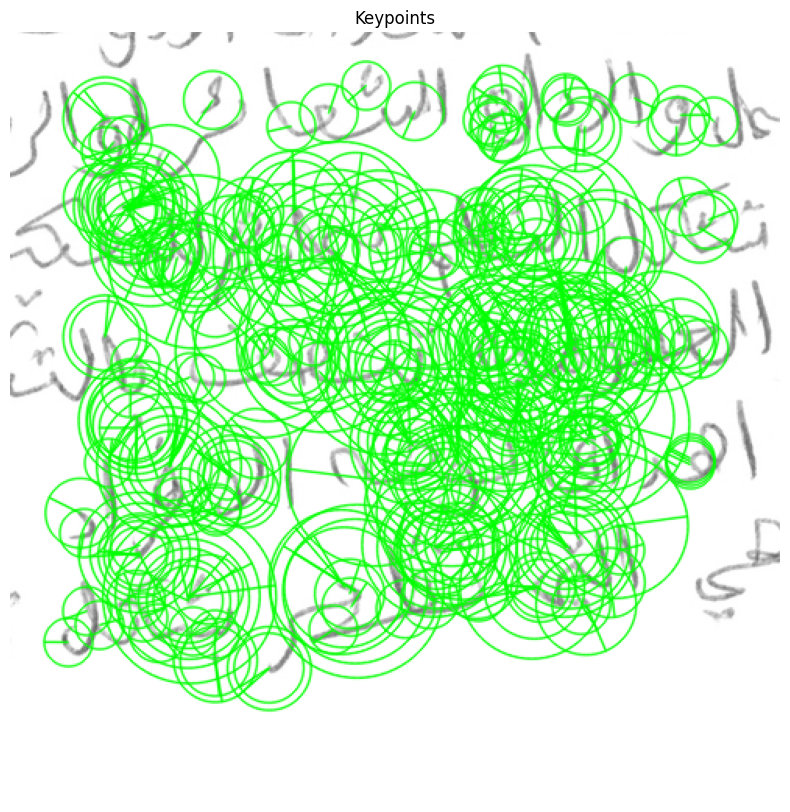

In [79]:
# Get the file path from train_df
file_path = train_df.loc[test_i, 'file_name']

# Load the image in grayscale
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

if True:
    # Extract the patch using x, y, x2, y2
    x, y, x2, y2 = train_df.loc[test_i, ['x', 'y', 'x2', 'y2']]
    image = image[y:y2, x:x2]

plot_keypoints(image, keypoints)

# extract all

In [80]:
def print_memory_usage():
    # Get the memory usage stats
    memory = psutil.virtual_memory()
    print(f"Memory used: {memory.used / (1024 ** 3):.2f} GB / Total memory: {memory.total / (1024 ** 3):.2f} GB")
    print(f"Available memory: {memory.available / (1024 ** 3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

In [81]:
# Function to print the current CPU usage
def print_cpu_usage():
    # psutil.cpu_percent() returns the CPU usage as a percentage
    cpu_usage = psutil.cpu_percent(interval=1)  # interval in seconds
    print(f"Current CPU usage: {cpu_usage}%")

In [15]:
'''print(train_df.loc[796, 'file_name'])
print(train_df.loc[795, 'file_name'])
# Load the image in grayscale
file_path= train_df.loc[796, 'file_name']
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Plot the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Keypoints")
plt.show()'''
keypoints = process_image_at_index(796, binarization_method='adaptive', keypoint_method='orb', 
                                           denoising_method='gaussian')#,skip=['denoising'])
print(len(keypoints))

500


In [82]:
keypoints_list = []

for i in range(len(train_df)):
#for i in range(100):
    #print(i)
    try:
        #print_cpu_usage()
        keypoints = process_image_at_index(i, True, binarization_method='adaptive', keypoint_method='orb', 
                                           denoising_method='gaussian')#, skip=['denoising'])
        keypoints_list.append(keypoints)
        '''print_cpu_usage()
        print_memory_usage()
        print("--------------------------------------------------")'''
    except FileNotFoundError as e:
        print(f"Skipping index {i}: {e}")
        keypoints_list.append([])
    if i % 500 == 0:
        print(f"Processed {i} images out of {len(train_df)}")
        print_memory_usage()
        keypoints_list_size_mb = sys.getsizeof(keypoints_list) / (1024 * 1024) #gives size in bytes, convert to MB
        print(f"Size of keypoints_list: {keypoints_list_size_mb:.2f} MB")
        print_cpu_usage()
        print("--------------------------------------------------")

Processed 0 images out of 2820
Memory used: 6.87 GB / Total memory: 7.87 GB
Available memory: 1.00 GB
Memory usage percentage: 87.3%
Size of keypoints_list: 0.00 MB
Current CPU usage: 23.8%
--------------------------------------------------
Processed 500 images out of 2820
Memory used: 6.82 GB / Total memory: 7.87 GB
Available memory: 1.05 GB
Memory usage percentage: 86.6%
Size of keypoints_list: 0.00 MB
Current CPU usage: 13.9%
--------------------------------------------------
Processed 1000 images out of 2820
Memory used: 6.79 GB / Total memory: 7.87 GB
Available memory: 1.09 GB
Memory usage percentage: 86.2%
Size of keypoints_list: 0.01 MB
Current CPU usage: 12.9%
--------------------------------------------------
Processed 1500 images out of 2820
Memory used: 7.02 GB / Total memory: 7.87 GB
Available memory: 0.85 GB
Memory usage percentage: 89.2%
Size of keypoints_list: 0.01 MB
Current CPU usage: 11.3%
--------------------------------------------------
Processed 2000 images out of

In [83]:
# Add a column with the number of keypoints to the dataframe
#train_df['num_keypoints'] = [len(kp) for kp in keypoints_list]

# Calculate the size of the keypoints_list in MB
keypoints_list_size_mb = sys.getsizeof(keypoints_list) / (1024 * 1024) #gives size in bytes, convert to MB
print(f"Size of keypoints_list: {keypoints_list_size_mb:.2f} MB")

Size of keypoints_list: 0.02 MB


In [84]:
train_df['num_keypoints'] = [len(kp) for kp in keypoints_list]

In [85]:
#get descriptive statistics on the number of keypoints
train_df['num_keypoints'].describe()

count    2820.000000
mean      300.636879
std         1.983272
min       281.000000
25%       300.000000
50%       300.000000
75%       301.000000
max       324.000000
Name: num_keypoints, dtype: float64

In [87]:
train_df['same_text'].describe()

count    2820.000000
mean        0.656028
std         0.475116
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: same_text, dtype: float64

In [88]:
def serialize_keypoints(keypoints):
    return [(kp.pt, kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in keypoints]
serialized_test = serialize_keypoints(keypoints_list[0]) 
print(serialized_test)

[((228.0, 34.0), 31.0, 139.28248596191406, 0.03329368680715561, 0, -1), ((331.0, 206.0), 31.0, 303.8557434082031, 0.019929461181163788, 0, -1), ((356.0, 42.0), 31.0, 268.50335693359375, 0.023974386975169182, 0, -1), ((317.0, 68.0), 31.0, 119.91817474365234, 0.014958355575799942, 0, -1), ((436.0, 273.0), 31.0, 206.53143310546875, 0.015501617453992367, 0, -1), ((75.0, 69.0), 31.0, 80.62826538085938, 0.02063177153468132, 0, -1), ((436.0, 275.0), 31.0, 207.98342895507812, 0.01683543622493744, 0, -1), ((246.0, 213.0), 31.0, 272.68792724609375, 0.01608808897435665, 0, -1), ((66.0, 70.0), 31.0, 126.2469482421875, 0.023297589272260666, 0, -1), ((436.0, 277.0), 31.0, 204.69456481933594, 0.014974493533372879, 0, -1), ((98.0, 147.0), 31.0, 96.22611236572266, 0.015660403296351433, 0, -1), ((49.0, 371.0), 31.0, 160.27835083007812, 0.025820234790444374, 0, -1), ((362.0, 215.0), 31.0, 60.757904052734375, 0.016489487141370773, 0, -1), ((139.0, 284.0), 31.0, 245.319580078125, 0.02403009682893753, 0, -1

In [89]:
serialized_keypoints = [serialize_keypoints(kp) for kp in keypoints_list]

In [90]:
import pickle

# Add metadata
metadata = {
    "description": "created from icdar_train_df_patches.csv on 29/4/25. This dataset extract the top 10 patches for each writer independently of the iseng and same_text values",
    "method": "orb, 300 nfeatures, binarization + denoising",
    "keypoints_list": serialized_keypoints
}

# Save the metadata and keypoints_list to a file using pickle
with open(f"{source_path}\\outputs\\preprocessed_data\\keypoints_list_orb_300_patches.pkl", "wb") as f:
    pickle.dump(metadata, f)



In [26]:
def deserialize_keypoints(data):
    return [cv2.KeyPoint(x=pt[0], y=pt[1], size=size, angle=angle,
                         response=response, octave=octave, class_id=class_id)
            for pt, size, angle, response, octave, class_id in data]

# Load from file
with open(f"{source_path}\\outputs\\preprocessed_data\\keypoints_list_orb_500.pkl", "rb") as f:
    metadata = pickle.load(f)

print(metadata["description"])
keypoints_list_retrieved = [deserialize_keypoints(kp) for kp in metadata["keypoints_list"]]

created from icdar_train_df_w_image_paths.csv on 29/4/25


In [29]:
print(keypoints_list_retrieved[0]) #should be same as before, 500 nfeatures

[< cv2.KeyPoint 00000282C79D1200>, < cv2.KeyPoint 00000282C79D12C0>, < cv2.KeyPoint 00000282C79D3F90>, < cv2.KeyPoint 00000282C79D0690>, < cv2.KeyPoint 00000282C79D0510>, < cv2.KeyPoint 00000282C79D3C30>, < cv2.KeyPoint 00000282C79D1440>, < cv2.KeyPoint 00000282C79D0B40>, < cv2.KeyPoint 00000282C79D3BD0>, < cv2.KeyPoint 00000282C79D3EA0>, < cv2.KeyPoint 00000282C81584B0>, < cv2.KeyPoint 00000282C8159020>, < cv2.KeyPoint 00000282C815AC40>, < cv2.KeyPoint 00000282C815AF40>, < cv2.KeyPoint 00000282C8158870>, < cv2.KeyPoint 00000282C815B9F0>, < cv2.KeyPoint 00000282C815B5A0>, < cv2.KeyPoint 00000282C81591D0>, < cv2.KeyPoint 00000282C815A6A0>, < cv2.KeyPoint 00000282C815AAC0>, < cv2.KeyPoint 00000282C8158CF0>, < cv2.KeyPoint 00000282C81FBBD0>, < cv2.KeyPoint 00000282C81FB330>, < cv2.KeyPoint 00000282C81F9BF0>, < cv2.KeyPoint 00000282C81FAD30>, < cv2.KeyPoint 00000282C81FB2A0>, < cv2.KeyPoint 00000282C81FB540>, < cv2.KeyPoint 00000282C81FACA0>, < cv2.KeyPoint 00000282C81FAF10>, < cv2.KeyPoin